In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import random
import time

DATA_DIR = "pytorch/data/animals/"
BATCH_SIZE = 24
EPOCHS = 12
IMG_SIZE = 224
LR = 0.0015
NUMBER_OF_IMAGES = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes

class_indices = {i: [] for i in range(len(class_names))}

for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

selected_indices = []
for label, indices in class_indices.items():
    random.shuffle(indices)
    selected_indices.extend(indices[:NUMBER_OF_IMAGES])

dataset = Subset(dataset, selected_indices)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class CnnVgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE//8) * (IMG_SIZE//8), 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CnnVgg16().to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.squeeze().int()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [48]:
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.float().unsqueeze(1).to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]: "
          f"Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_acc:.3f}, "
          f"Test Accuracy: {test_acc:.3f}")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

torch.save(model.state_dict(), "pytorch/saved_models/cat_dog_cnn.pt")
print("Model saved as pytorch/saved_models/cat_dog_cnn.pt")

Epoch [1/12]: Loss: 0.7067, Train Accuracy: 0.589, Test Accuracy: 0.536
Epoch [2/12]: Loss: 0.6674, Train Accuracy: 0.608, Test Accuracy: 0.551
Epoch [3/12]: Loss: 0.6564, Train Accuracy: 0.627, Test Accuracy: 0.593
Epoch [4/12]: Loss: 0.6136, Train Accuracy: 0.650, Test Accuracy: 0.620
Epoch [5/12]: Loss: 0.5885, Train Accuracy: 0.727, Test Accuracy: 0.660
Epoch [6/12]: Loss: 0.5065, Train Accuracy: 0.785, Test Accuracy: 0.718
Epoch [7/12]: Loss: 0.4722, Train Accuracy: 0.811, Test Accuracy: 0.683
Epoch [8/12]: Loss: 0.4056, Train Accuracy: 0.855, Test Accuracy: 0.689
Epoch [9/12]: Loss: 0.3088, Train Accuracy: 0.914, Test Accuracy: 0.696
Epoch [10/12]: Loss: 0.2230, Train Accuracy: 0.942, Test Accuracy: 0.709
Epoch [11/12]: Loss: 0.1721, Train Accuracy: 0.951, Test Accuracy: 0.670
Epoch [12/12]: Loss: 0.1269, Train Accuracy: 0.957, Test Accuracy: 0.721

Total training time: 656.49 seconds
Model saved as pytorch/saved_models/cat_dog_cnn.pt


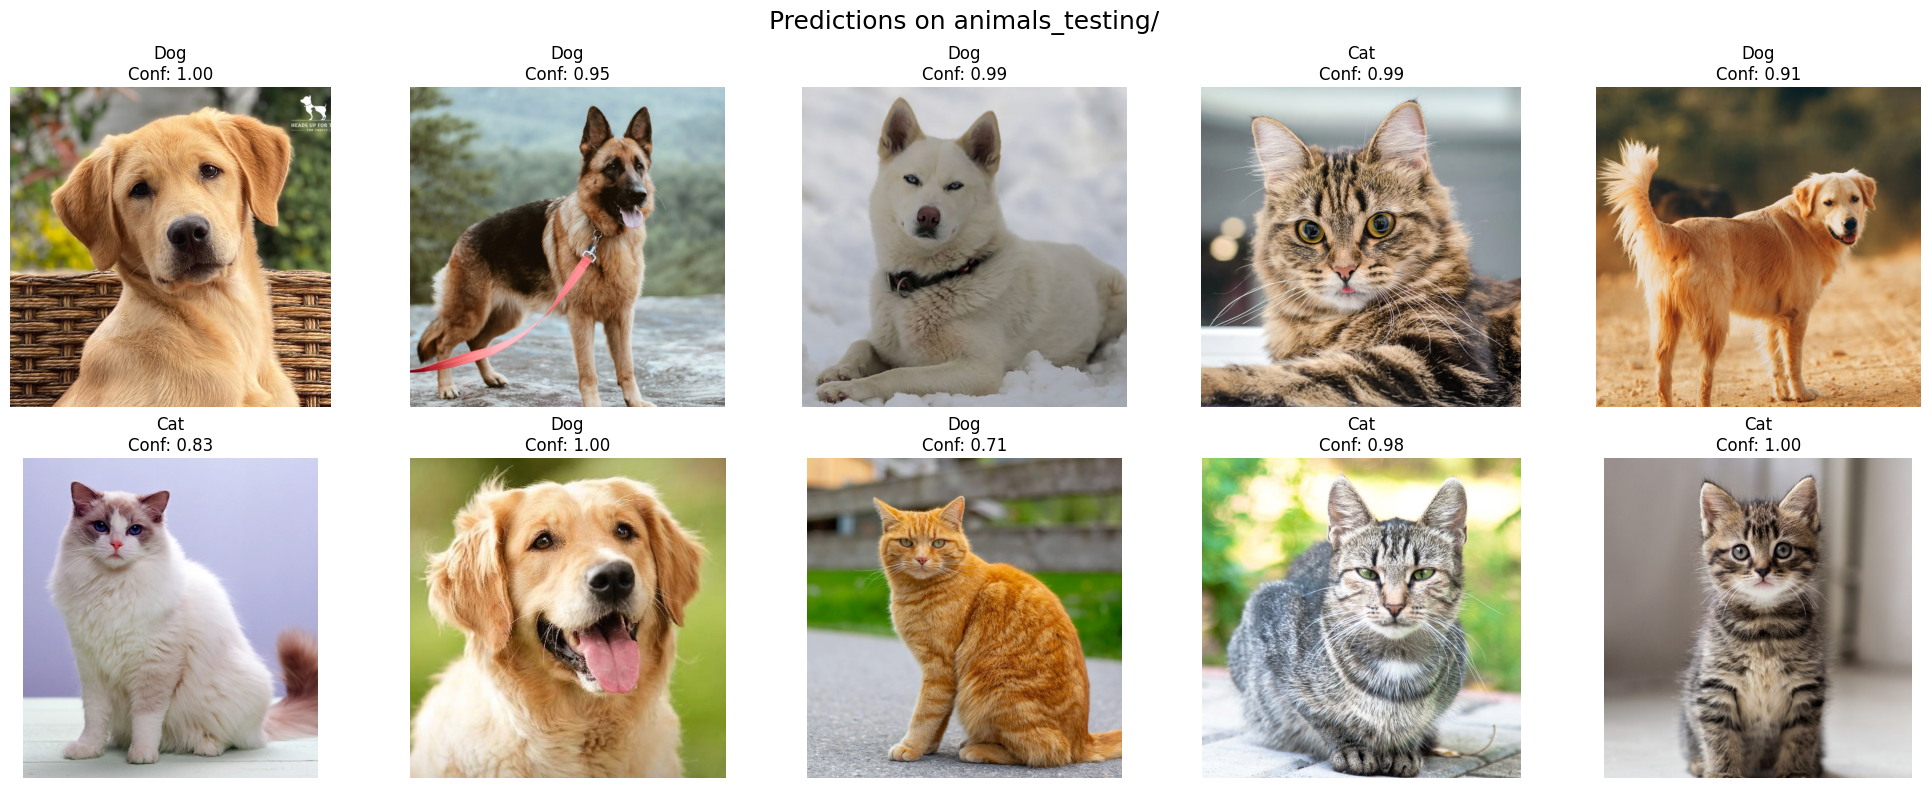

In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "saved_models/cat_dog_cnn.pt"
TEST_FOLDER = "data/animals/testing"

model = CnnVgg16().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

all_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith(('.jpg','.jpeg','.png'))]
samples = random.sample(all_files, min(10, len(all_files)))
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, img_path in enumerate(samples):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()

    pred_label = "Dog" if prob > 0.5 else "Cat"
    confidence = prob if prob > 0.5 else 1 - prob

    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(image)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"{pred_label}\nConf: {confidence:.2f}")

plt.suptitle("Predictions on animals_testing/", fontsize=18)
plt.tight_layout()
plt.show()
